<a href="https://colab.research.google.com/github/asnoldy02-cell/sds510/blob/main/Module_3_Essentials_Crime_Rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install geopandas shapely geopy --quiet

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import statsmodels.api as sm
from google.colab import files
import numpy as np

In [59]:
print("Upload your CSVs and ZIP shapefile files (.shp, .shx, .dbf, .prj)")
uploaded = files.upload()

Upload your CSVs and ZIP shapefile files (.shp, .shx, .dbf, .prj)


Saving Street_Traffic_Volumes.csv to Street_Traffic_Volumes (4).csv
Saving crime-data_crime-data_crimestat.csv to crime-data_crime-data_crimestat (2).csv


In [60]:
crime_file = "crime-data_crime-data_crimestat.csv"
traffic_file = "Street_Traffic_Volumes.csv"

In [62]:
display(crime_df.columns)

Index(['INC NUMBER', 'OCCURRED ON', 'OCCURRED TO', 'UCR CRIME CATEGORY',
       '100 BLOCK ADDR', 'ZIP', 'PREMISE TYPE', 'GRID'],
      dtype='object')

In [65]:
print("Crime data preview:")
display(crime_df.head())

Crime data preview:


,INC NUMBER,OCCURRED ON,OCCURRED TO,UCR CRIME CATEGORY,100 BLOCK ADDR,ZIP,PREMISE TYPE,GRID
0,201600000594484,2015-11-01,NaT,RAPE,13XX E ALMERIA RD,85006.0,SINGLE FAMILY HOUSE,BD30
1,201500002102327,2015-11-01,2015-11-01 09:00:00,LARCENY-THEFT,51XX N 15TH ST,85014.0,APARTMENT,BJ30
2,201500002168686,2015-11-01,2015-11-11 09:30:00,LARCENY-THEFT,14XX E HIGHLAND AVE,85014.0,PARKING LOT,BI30
3,201500002102668,2015-11-01,2015-11-01 11:50:00,MOTOR VEHICLE THEFT,69XX W WOOD ST,85043.0,SINGLE FAMILY HOUSE,AF12
4,201600000052855,2015-11-01,2016-01-09 00:00:00,MOTOR VEHICLE THEFT,N 43RD AVE & W CACTUS RD,85029.0,SINGLE FAMILY HOUSE,DA19


In [66]:

print("Traffic data preview:")
display(traffic_df.head())

Traffic data preview:


,X,Y,OBJECTID,ID,IsNTMT,STREET,BLOCKNUM,BLOCKDIR,CROSSSTREET,CROSSBLOCK,...,COUNTTYPE,DIRECTION,DESCRIPTION,DISTRICT,COUNTSTATION,BUDGETYR,COMMENTS,VERIFIEDON,AVG_SPEED,geometry
0,646180.302822,8.949711e+05,25947,13780,0,GRAND AVE,1200,N,ROOSEVELT ST,1500,...,MID4,South Bound,Special,4,2420,2016,NaN,2015/09/10 15:08:13+00,37.0,POINT (646180.302821521 894971.058398947)
1,646180.302822,8.949711e+05,25948,13780,0,GRAND AVE,1200,N,16TH AVE,1600,...,MID4,South Bound,Special,4,2420,2016,NaN,2015/09/09 22:06:44+00,37.0,POINT (646180.302821521 894971.058398947)
2,646226.129265,8.950183e+05,25949,13780,0,GRAND AVE,1200,N,ROOSEVELT ST,1500,...,MID4,North Bound,Special,4,2420,2016,NaN,2015/09/10 15:08:13+00,37.0,POINT (646226.129265092 895018.281496063)
3,646226.129265,8.950183e+05,25950,13780,0,GRAND AVE,1200,N,16TH AVE,1600,...,MID4,North Bound,Special,4,2420,2016,NaN,2015/09/09 22:06:44+00,37.0,POINT (646226.129265092 895018.281496063)
4,645643.030184,1.012856e+06,25951,13784,1,DOVE VALLEY RD,33000,N,16TH AVE,1580,...,MID2,West Bound,Cut Thru Traffic,2,5483,2016,NaN,2015/09/14 20:16:20+00,46.0,POINT (645643.030183729 1012855.87007874)


In [73]:
crime_by_zip = crime_df.groupby("ZIP").size().reset_index(name="crime_count")


In [74]:

if "STREET" in traffic_df.columns:
    traffic_by_street = traffic_df.groupby("STREET").agg(
        total_traffic_volume=('VOLUME','sum'),
        mean_traffic_volume=('VOLUME','mean')
    ).reset_index()
    print("Traffic aggregated by STREET:")
    display(traffic_by_street.head())
else:
    print("Traffic CSV has no STREET column. Aggregating all traffic as one total value.")
    traffic_df['STREET'] = 'ALL'
    traffic_by_street = traffic_df.groupby("STREET").agg(
        total_traffic_volume=('VOLUME','sum'),
        mean_traffic_volume=('VOLUME','mean')
    ).reset_index()
    display(traffic_by_street.head())

Traffic aggregated by STREET:


,STREET,total_traffic_volume,mean_traffic_volume
0,101ST AVE,2995,998.333333
1,103RD AVE,16634,1279.538462
2,105TH AVE,793,396.500000
3,107TH AVE,57111,4759.250000
4,10TH ST,1906,476.500000


In [75]:
overall_traffic_total = traffic_by_street['total_traffic_volume'].sum()
crime_by_zip['total_traffic_volume'] = overall_traffic_total
crime_by_zip['mean_traffic_volume'] = traffic_by_street['mean_traffic_volume'].mean()

merged = crime_by_zip.copy()
display(merged.head())

,ZIP,crime_count,total_traffic_volume,mean_traffic_volume
0,85003.0,8584,26995328,3447.46088
1,85004.0,9292,26995328,3447.46088
2,85006.0,12409,26995328,3447.46088
3,85007.0,11372,26995328,3447.46088
4,85008.0,28921,26995328,3447.46088


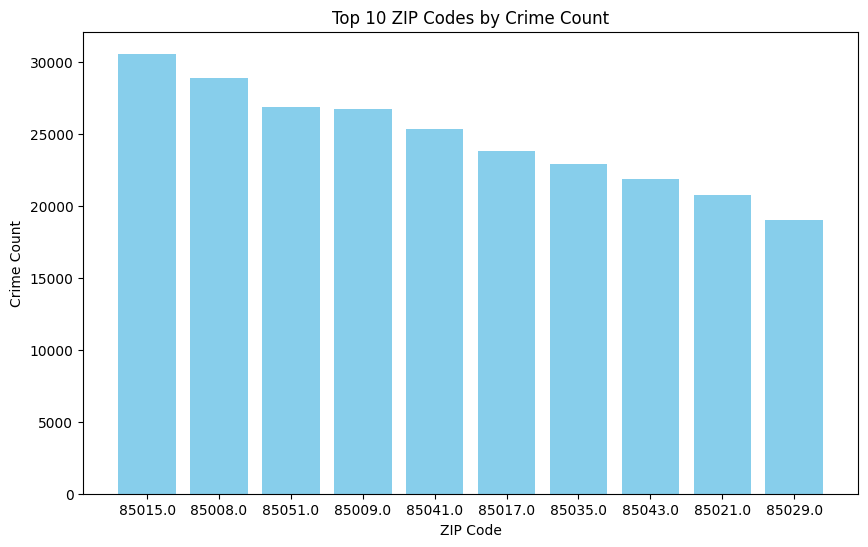

In [76]:
top10_crime = merged.nlargest(10, "crime_count")
plt.figure(figsize=(10,6))
plt.bar(top10_crime["ZIP"].astype(str), top10_crime["crime_count"], color='skyblue')
plt.xlabel("ZIP Code")
plt.ylabel("Crime Count")
plt.title("Top 10 ZIP Codes by Crime Count")
plt.show()

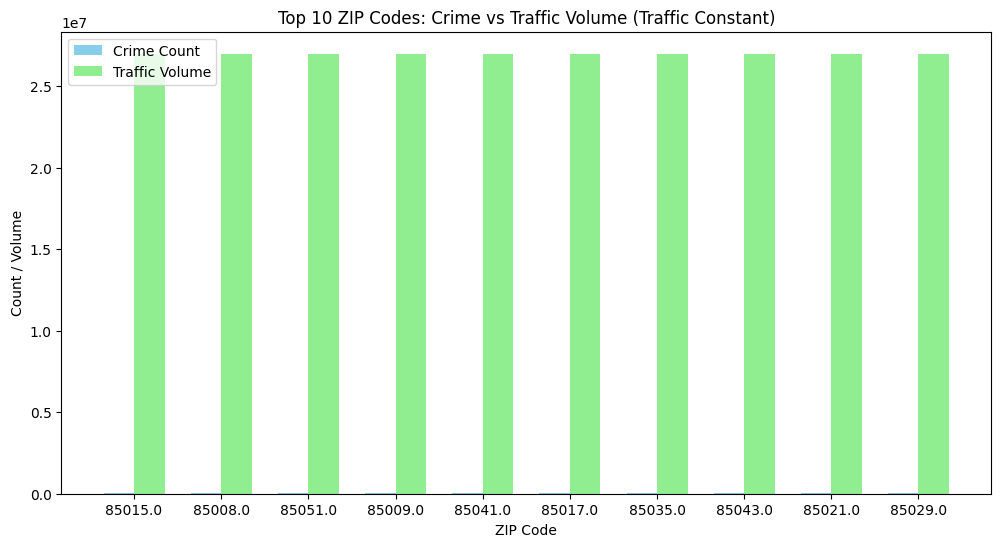

In [78]:
x = np.arange(len(top10_crime))
width = 0.35
plt.figure(figsize=(12,6))
plt.bar(x - width/2, top10_crime["crime_count"], width, label="Crime Count", color='skyblue')
plt.bar(x + width/2, [overall_traffic_total]*len(top10_crime), width, label="Traffic Volume", color='lightgreen')
plt.xticks(x, top10_crime["ZIP"].astype(str))
plt.xlabel("ZIP Code")
plt.ylabel("Count / Volume")
plt.title("Top 10 ZIP Codes: Crime vs Traffic Volume (Traffic Constant)")
plt.legend()
plt.show()

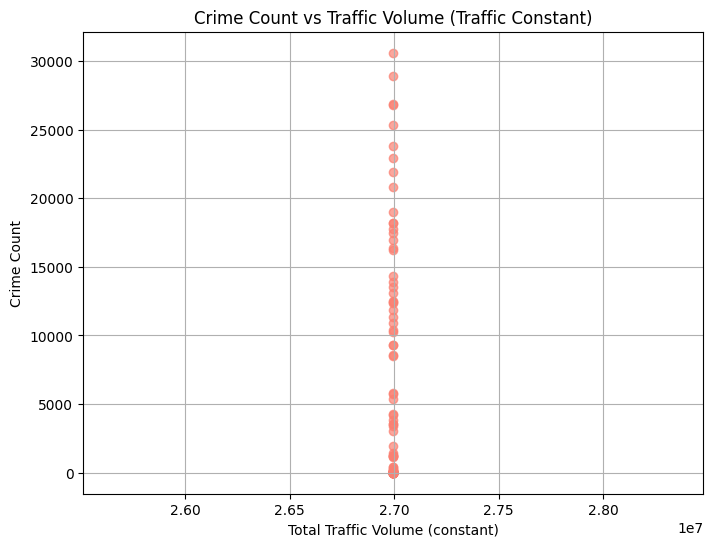

In [79]:
plt.figure(figsize=(8,6))
plt.scatter([overall_traffic_total]*len(merged), merged["crime_count"], alpha=0.7, color='salmon')
plt.xlabel("Total Traffic Volume (constant)")
plt.ylabel("Crime Count")
plt.title("Crime Count vs Traffic Volume (Traffic Constant)")
plt.grid(True)
plt.show()

In [80]:
X = merged[["total_traffic_volume"]]
X = sm.add_constant(X)
y = merged["crime_count"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 02 Nov 2025   Prob (F-statistic):                nan
Time:                        22:21:15   Log-Likelihood:                -1217.9
No. Observations:                 117   AIC:                             2438.
Df Residuals:                     116   BIC:                             2440.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
total_traffic_volume     0.0002 

In [81]:
merged.to_csv("phoenix_crime_traffic_essentials.csv", index=False)
print("Merged CSV saved as 'phoenix_crime_traffic_essentials.csv'.")

Merged CSV saved as 'phoenix_crime_traffic_essentials.csv'.
